# Prepare data for training
To-do:
- preload images
- separate images into train and test set (maybe 90:10)

In [1]:
import tensorflow as tf

import nibabel as nib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import ndimage
from pathlib import Path

from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

from sklearn.utils import class_weight

import sys
sys.path.append(r"/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/Brain_Mets_Classification")

import brain_mets_classification.custom_funcs as funcs

from tqdm import tqdm

import shutil

import imageio
import cv2

### Imfusion Lables Preparation

export .txt file and convert segmentation masks to unsigned char for ImFusion Label annotations

In [9]:
# move only the fully preprocessed files into new patient folders
path_to_auto_segmented_files = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/segmented_AURORA_n4_20240614-170748")
path_to_all_preprocessed_files = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/preprocessed_n4_brainlesion_percentile_20240612-083743")
path_to_unsigned_segmentations = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/unsigned_segmentations")

path_to_txt_file = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/files_to_segment.txt"

In [12]:
# create txt file that lists all the paths to the preprocessed t1c images and after that separated by a semi-colon the path to the multilabel segmentation

preprocessed_patients = [patient for patient in os.listdir(str(path_to_all_preprocessed_files)) if os.path.isdir(os.path.join(path_to_all_preprocessed_files / patient))]

for patient in tqdm(preprocessed_patients):

    # go into perc_normalized dir
    # create new patient dir in path_to_only_preprocessed
    # copy contents
    
    path_to_perc_normalized = path_to_all_preprocessed_files / patient / "perc_normalized"

    t1c_file = [file for file in os.listdir(str(path_to_perc_normalized)) if "t1c" in file][0]
    path_to_t1c_file = path_to_perc_normalized / t1c_file

    path_to_segmentation = path_to_auto_segmented_files / patient
    if not path_to_segmentation.exists():
        print(f"directory {path_to_segmentation} does not exist")
        continue

    multimodal_segmentation_file = [file for file in os.listdir(str(path_to_segmentation)) if "multi-modal" in file][0]
    path_to_multimodal_segmentation_file = path_to_segmentation / multimodal_segmentation_file

    mask = nib.load(path_to_multimodal_segmentation_file)
    data = mask.get_fdata()

    # Convert to unsigned bytes
    data_uint8 = data.astype(np.uint8)

    # Create a new Nifti1Image
    new_img = nib.Nifti1Image(data_uint8, affine = mask.affine)

    new_img.header.set_data_dtype(np.uint8)
    new_img.header['datatype'] = 2  # 2 corresponds to unsigned char in NIfTI format
    new_img.header['bitpix'] = 8  # 8 bits per voxel

    path_to_unsinged_mask = path_to_unsigned_segmentations / multimodal_segmentation_file

    nib.save(new_img, path_to_unsinged_mask)

    f = open(path_to_txt_file, "a")
    f.write(f"{path_to_t1c_file};{path_to_unsinged_mask}\n")
    f.close()

100%|██████████| 492/492 [00:13<00:00, 35.90it/s]


In [13]:
output_file = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/unsigned_segmentations/sub-01009590_multi-modal_segmentation.nii.gz"

img = nib.load(output_file)
print(img.get_data_dtype())  # This should print uint8

uint8


prints patients that have been removed from the training

In [16]:
path_to_tsv = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Dateien/dataset_patients_05_24.tsv"

training_patients = pd.read_csv(path_to_tsv, sep="\t")

patient_ids = training_patients["participant_id"].tolist()
print(patient_ids)

preprocessed_patients = [patient for patient in os.listdir(str(path_to_all_preprocessed_files)) if os.path.isdir(os.path.join(path_to_all_preprocessed_files / patient))]

for patient in preprocessed_patients:
    if patient not in patient_ids:
        print(patient)

['sub-01005097', 'sub-01005630', 'sub-01006290', 'sub-01009590', 'sub-01015961', 'sub-01018613', 'sub-01021714', 'sub-01021993', 'sub-01022787', 'sub-01025630', 'sub-01031243', 'sub-01038520', 'sub-01040149', 'sub-01041137', 'sub-01055292', 'sub-01056598', 'sub-01056884', 'sub-01064662', 'sub-01071055', 'sub-01072344', 'sub-01083248', 'sub-01087386', 'sub-01098043', 'sub-01099901', 'sub-01104996', 'sub-01106844', 'sub-01108350', 'sub-01109318', 'sub-01111974', 'sub-01117914', 'sub-01117958', 'sub-01119720', 'sub-01122863', 'sub-01125016', 'sub-01130173', 'sub-01130856', 'sub-01131702', 'sub-01134825', 'sub-01138456', 'sub-01147272', 'sub-01150136', 'sub-01152379', 'sub-01164049', 'sub-01164986', 'sub-01169240', 'sub-01188297', 'sub-01189050', 'sub-01190670', 'sub-01190738', 'sub-01196057', 'sub-01199093', 'sub-01201117', 'sub-01201482', 'sub-01204563', 'sub-01205171', 'sub-01205745', 'sub-01207036', 'sub-01213140', 'sub-01214172', 'sub-01214417', 'sub-01216717', 'sub-01220269', 'sub-01

In [ ]:
import nibabel as nib
import numpy as np

# Load the .nii file
img = nib.load('path_to_your_label.nii')
data = img.get_fdata()

# Convert to unsigned bytes
data_uint8 = data.astype(np.uint8)

# Create a new Nifti1Image
new_img = nib.Nifti1Image(data_uint8, img.affine, img.header)

# Save the new .nii file
nib.save(new_img, 'path_to_your_label_uint8.nii')

In [4]:
# copy preprocessed files into new patient folders
preprocessed_patients = [patient for patient in os.listdir(str(path_to_all_preprocessed_files)) if os.path.isdir(os.path.join(path_to_all_preprocessed_files / patient))]

for patient in tqdm(preprocessed_patients):

    # go into perc_normalized dir
    # create new patient dir in path_to_only_preprocessed
    # copy contents
    
    path_to_perc_normalized = path_to_all_preprocessed_files / patient / "perc_normalized"

    path_to_new_patient_folder = path_to_only_preprocessed / patient
    os.mkdir(path_to_new_patient_folder)

    files_to_copy = [file for file in os.listdir(str(path_to_perc_normalized)) if not file.endswith(".nii.gz")]

    for file in files_to_copy:
        shutil.copy(path_to_perc_normalized / file, path_to_new_patient_folder)

## Regensburg

### Clean up data

CAVE: remove patient sub-01383503 from training as the cerebellum is not fully displayed

In [2]:
# set pandas random seed to 42
np.random.seed(42)

In [3]:
#path_to_patients_tsv = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/rawdata/participants.tsv")
#path_to_patients_tsv = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Dateien/dataset_patients_05_24.tsv")
path_to_patients_tsv = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Dateien/participants_01_08_24.tsv")

# old: path_to_preprocessed_images = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/preprocessed_brainlesion_allpatients")
# path_to_preprocessed_images = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/preprocessed_brainlesion_allpatients")
#path_to_preprocessed_images = Path("/Users/LennartPhilipp/Desktop/testing_data/derivatives/preprocessed_n4_brainlesion_percentile_20240611-125716")
path_to_preprocessed_images = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/preprocessed_n4_brainlesion_percentile_20240612-083743")

Read .tsv file with all the patients

In [4]:
training_patients = pd.read_csv(path_to_patients_tsv, sep="\t", index_col=False)

# drop patient sub-01383503
patient_to_drop_index = training_patients.index[training_patients["participant_id"] == "sub-01383503"]
training_patients.drop(index=patient_to_drop_index, inplace=True)
training_patients.reset_index(drop=True, inplace=True)
#training_patients = training_patients.sample(frac=1) #shuffles the dataset

print(f"Before removing unfit files: {len(training_patients)}")
patient_files_list = os.listdir(path_to_preprocessed_images)
for index, row in training_patients.iterrows():
    if training_patients["participant_id"][index] not in patient_files_list:
        training_patients.drop(index=index, inplace=True)

print(f"After removing unfit files: {len(training_patients)}")
training_patients.reset_index(drop=True, inplace=True)

# shuffle dataset
training_patients = training_patients.sample(frac=1).reset_index(drop=True)

patient_ids = training_patients["participant_id"].tolist()

Before removing unfit files: 473
After removing unfit files: 471


### Unify primary classes

In [ ]:
#copy of cancer_primaries_dict from config.py (22_07_2024)

# cancer_primaries_dict = {   '1a': 'small cell lung cancer',
#                             '1b': 'squamous cell lung cancer',
#                             '1c': 'adenocarcinoma of the lung',
#                             '1d': 'large cell lung cancer',
#                             '1e': 'NSCLC',
#                             '1f': 'lung cancer, other',
#                             '1g': 'lung cancer, exact histology unknown',
#                             '2': 'breast cancer',
#                             '3': 'prostate cancer',
#                             '4': 'testicular cancer',
#                             '5': 'renal cell carcinoma',
#                             '6': 'transitional cell carcinoma', # also called urothelial carcinoma
#                             '7': 'vulvar carcinoma',
#                             '8': 'cervical cancer',
#                             '9': 'endometrial cancer',
#                             '10': 'ovarian cell carcinoma',
#                             '11a': 'osteosarcoma',
#                             '11b': 'liposarcoma',
#                             '11c': 'leiomyosarcoma',
#                             '11d': 'rhabdomyosarcoma',
#                             '11e': 'synovial sarcoma',
#                             '11f': 'solitary fibrous tumor',
#                             '11g': 'sarcoma, other',
#                             '11h': 'sarcoma, exact histology unknown',
#                             '12': 'melanoma',
#                             '13': 'lacrimal gland carcinoma',
#                             '14': 'salivary gland cancer',
#                             '15': 'oral squamous cell carcinoma',
#                             '16': 'adenoid cystic carcinoma',
#                             '17': 'laryngeal cancer',
#                             '18': 'thyroid cancer',
#                             '19': 'esophageal cancer',
#                             '20': 'gastric cancer',
#                             '21': 'pancreatic cancer',
#                             '22': 'cholangiocellular carcinoma',
#                             '23': 'colorectal cancer',
#                             '24': 'NET', # = neuroendocrine tumors
#                             '25': 'MiNEN', # = mixed neuroendocrine non-neuroendocine neuroplasms
#                             '26a': 'DSRCT', # = Desmoplastic small-round-cell Tumor
#                             '26b': 'mesothelioma, other',
#                             '27': 'thymoma',
#                             '28': 'plasmacytoma',
#                             '29': 'cancer of unknown primary'
# }

In [5]:
# primaries are written like this: 1e, 25, 13, 2f, etc., for the full list see config.py
# given a certain amount of classes, e.g. 3:
# create the following classes: lung, melanoma, other
primaries_array_dict = pd.Series(training_patients.primary.values, index=training_patients.participant_id).to_dict()

print("Original Primaries Dict:")
print(primaries_array_dict)
print()

def compress_primaries_dict(primaries_dict):

    #primaries_dict_copy = primaries_dict.copy()

    for key, value in primaries_dict.items():
        clean_primary = ''.join(filter(str.isdigit, value))
        primaries_dict[key] = clean_primary
    
    print(primaries_dict)

    for key, value in primaries_dict.items():
        primary_num = int(value)

        renamed_primary = 0

        # compress all the genitourinary cancers togehter (3-10)
        if primary_num >= 3 and primary_num <= 10:
            renamed_primary = 3
        # compress all the gastrointestinal cancers together (19-25)
        elif primary_num >= 19 and primary_num <= 25:
            renamed_primary = 19
        # compress all the head and neck cancers together (13-18)
        elif primary_num >= 13 and primary_num <= 18:
            renamed_primary = 13
        else:
            renamed_primary = primary_num

        primaries_dict[key] = renamed_primary
    
    print(primaries_dict)
    return primaries_dict


def return_specific_primaries_dict(primaries_dict, specific_classes, dataset):
    """
    Replace items in the primaries_array that are not in the specified classes with "other".
    
    Args:
    primaries_array (array): Array of primary classes.
    specific_classes (array): Array of specific classes to include.
    dataset (str): Name of the dataset ("Regensburg" or "Yale").
    
    Returns:
    array: Updated primaries_array with classes replaced as specified.
    """

    # go through the list and replace each iteam that is not in the specified classes with "other"

    if dataset == "Regensburg":

        for specific_class in specific_classes:

            match specific_class:
                case 1: # lung
                    
                    for key, value in primaries_dict.items():
                        if value == 1:
                            primaries_dict[key] = 101

                case 2: # melanoma

                    for key, value in primaries_dict.items():
                        if value == 12:
                            primaries_dict[key] = 102
                case 3: # breast

                    for key, value in primaries_dict.items():
                        if value == 2:
                            primaries_dict[key] = 103
                case 4: # genito urinary

                    for key, value in primaries_dict.items():
                        if value == 3:
                            primaries_dict[key] = 104
                case 5: # gastro

                    for key, value in primaries_dict.items():
                        if value == 19:
                            primaries_dict[key] = 105
                case _:
                    pass
    
    elif dataset == "Yale":

        for specific_class in specific_classes:

            match specific_class:
                case 1: # lung

                    for key, value in primaries_dict.items():
                        if value == 1:
                            primaries_dict[key] = 101
                    #primaries_array = primaries_array.replace(0, 101)
                case 2: # melanoma

                    for key, value in primaries_dict.items():
                        if value == 4:
                            primaries_dict[key] = 102
                    #primaries_array = primaries_array.replace(4, 102)
                case 3: # breast

                    for key, value in primaries_dict.items():
                        if value == 1:
                            primaries_dict[key] = 103
                    #primaries_array = primaries_array.replace(1, 103)
                case 4: # genito urinary, actually in this case only renal cell carcinoma
                    
                    for key, value in primaries_dict.items():
                        if value == 6:
                            primaries_dict[key] = 104
                    #primaries_array = primaries_array.replace(6, 104)
                case 5: # gastro

                    for key, value in primaries_dict.items():
                        if value == 2:
                            primaries_dict[key] = 105
                    #primaries_array = primaries_array.replace(2, 105)
                case _:
                    pass

    print(primaries_dict)

    for key, value in primaries_dict.items():
        if value < 100:
            primaries_dict[key] = 0

    print(primaries_dict)

    counter = 0

    for specific_class in specific_classes:
        specific_class = specific_class + 100
        counter += 1

        for key, value in primaries_dict.items():
            if value == specific_class:
                primaries_dict[key] = counter
    
    print(primaries_dict)

    return primaries_dict

print("Compress Primaries Dict Function output:")
compressed = compress_primaries_dict(primaries_array_dict)
print()

print("Return Specific Primaries Dict Function output:")
specific_primaries_dict = return_specific_primaries_dict(compressed, [1,2,3,4,5], "Regensburg")

print(pd.Series(specific_primaries_dict.values()).value_counts())

Original Primaries Dict:
{'sub-01205745': '12', 'sub-01288350': '23', 'sub-01125016': '11b', 'sub-02183443': '1e', 'sub-02145870': '1a', 'sub-01710250': '1c', 'sub-01686968': '1f', 'sub-01025630': '1a', 'sub-02051037': '1a', 'sub-01281168': '12', 'sub-01314225': '1b', 'sub-02177752': '1a', 'sub-02126982': '23', 'sub-02153522': '1g', 'sub-80004059': '1c', 'sub-02138280': '1c', 'sub-01515235': '12', 'sub-01381621': '8', 'sub-02146286': '1a', 'sub-01311383': '1c', 'sub-01005097': '1e', 'sub-93003757': '5', 'sub-01038520': '1a', 'sub-01771120': '1a', 'sub-01309950': '23', 'sub-01677324': '12', 'sub-02173158': '1c', 'sub-01307298': '1a', 'sub-01117958': '1f', 'sub-01587295': '6', 'sub-01421533': '1c', 'sub-01732889': '1c', 'sub-01398968': '1a', 'sub-02122538': '1a', 'sub-01071055': '5', 'sub-01147272': '1a', 'sub-02094837': '1c', 'sub-93002557': '23', 'sub-01947074': '23', 'sub-01484016': '12', 'sub-01895825': '12', 'sub-01773716': '1e', 'sub-01505384': '12', 'sub-01565091': '23', 'sub-0201

In [12]:
# primaries are written like this: 1e, 25, 13, 2f, etc., for the full list see config.py
# given a certain amount of classes, e.g. 3:
# create the following classes: lung, melanoma, other
primaries_array_dict = pd.Series(training_patients.primary.values, index=training_patients.participant_id).to_dict()
primaries_array = training_patients["primary"]

#print(primaries_array)

#print(primaries_array.value_counts())




def compress_primaries(primaries_array):
    '''moves all the primaries from different subclasses into one class, e.g. 1a-f become 1 etc.'''
    
    letters_removed_primaries = []

    # remove any letters from the list
    for primary in primaries_array:
        clean_primary = ''.join(filter(str.isdigit, primary))
        letters_removed_primaries.append(clean_primary)

    compressed_primaries = []

    for primary in letters_removed_primaries:
        primary_num = int(primary)
        renamed_primary = 0
        # compress all the genitourinary cancers togehter (3-10)
        if primary_num >= 3 and primary_num <= 10:
            renamed_primary = 3
        # compress all the gastrointestinal cancers together (19-25)
        elif primary_num >= 19 and primary_num <= 25:
            renamed_primary = 19
        # compress all the head and neck cancers together (13-18)
        elif primary_num >= 13 and primary_num <= 18:
            renamed_primary = 13
        else:
            renamed_primary = primary_num
        
        compressed_primaries.append(renamed_primary)
        
    return compressed_primaries

compressed_list = pd.Series(compress_primaries(primaries_array))
#print(compressed_list.value_counts())

def return_specific_primaries(primaries_array, specific_classes, dataset):
    """
    Replace items in the primaries_array that are not in the specified classes with "other".
    
    Args:
    primaries_array (array): Array of primary classes.
    specific_classes (array): Array of specific classes to include.
    dataset (str): Name of the dataset ("Regensburg" or "Yale").
    
    Returns:
    array: Updated primaries_array with classes replaced as specified.
    """

    # go through the list and replace each iteam that is not in the specified classes with "other"

    if dataset == "Regensburg":

        for specific_class in specific_classes:

            match specific_class:
                case 1: # lung
                    primaries_array = primaries_array.replace(1, 101)
                case 2: # melanoma
                    primaries_array = primaries_array.replace(12, 102)
                case 3: # breast
                    primaries_array = primaries_array.replace(2, 103)
                case 4: # genito urinary
                    primaries_array = primaries_array.replace(3, 104)
                case 5: # gastro
                    primaries_array = primaries_array.replace(19, 105)
                case _:
                    pass
    
    elif dataset == "Yale":

        for specific_class in specific_classes:

            match specific_class:
                case 1: # lung
                    primaries_array = primaries_array.replace(0, 101)
                case 2: # melanoma
                    primaries_array = primaries_array.replace(4, 102)
                case 3: # breast
                    primaries_array = primaries_array.replace(1, 103)
                case 4: # genito urinary, actually in this case only renal cell carcinoma
                    primaries_array = primaries_array.replace(6, 104)
                case 5: # gastro
                    primaries_array = primaries_array.replace(2, 105)
                case _:
                    pass

    for primary in primaries_array:
            if primary < 100:
                primaries_array = primaries_array.replace(primary, 0)
    
    counter = 0

    for specific_class in specific_classes:
        
        specific_class = specific_class + 100

        counter += 1

        primaries_array = primaries_array.replace(specific_class, counter)

    #print(primaries_array.value_counts())

    return primaries_array

def return_modified_primaries(primaries_array, num_classes):
    '''returns an array where all the items are grouped into x classes depending on num_classes
    e.g. if num_classes = 2, then only the most frequent category (lung cancer) gets returned while all the other categories are grouped as \'other\''''
    
    # get most frequent classes
    # go through the list and replace each item that is not in the most frequent classes with "other"
    # the following code is probably one the least efficient ways to solve this problem
    # but it works so who am I to change it
    different_primaries = []

    for primary in primaries_array:
        if primary not in different_primaries:
            different_primaries.append(primary)
    
    count_dict = {}

    #print(different_primaries)

    for dif_primary in different_primaries:
        count = list(primaries_array).count(dif_primary)
        count_dict[count] = dif_primary
    
    sorted_dict = sorted(count_dict, reverse=True)

    white_list_count = []

    for n in range(num_classes - 1):
        white_list_count.append(sorted_dict[n])

    white_list = []
    for n in white_list_count:
        white_list.append(count_dict[n])

    modified_array = []

    for primary in primaries_array:
        modified_primary = 0

        if primary not in white_list:
            modified_primary = 0
        else:
            modified_primary = primary
        
        modified_array.append(modified_primary)
    
    return modified_array

test_class_primaries = return_specific_primaries(compressed_list, specific_classes = [1,2,3,4,5], dataset="Regensburg")
#print(test_class_primaries)
print(test_class_primaries.value_counts())
# two_classes_primaries = pd.Series(return_modified_primaries(compressed_list, num_classes=2))

# print(two_classes_primaries)
# print(two_classes_primaries.value_counts())

# # create dict of patient IDs to primaries
patient_primaries_dict = dict(zip(patient_ids, test_class_primaries))
print(patient_primaries_dict)

1    255
2     74
4     42
3     40
5     32
0     28
Name: count, dtype: int64
{'sub-01205745': 2, 'sub-01288350': 5, 'sub-01125016': 0, 'sub-02183443': 1, 'sub-02145870': 1, 'sub-01710250': 1, 'sub-01686968': 1, 'sub-01025630': 1, 'sub-02051037': 1, 'sub-01281168': 2, 'sub-01314225': 1, 'sub-02177752': 1, 'sub-02126982': 5, 'sub-02153522': 1, 'sub-80004059': 1, 'sub-02138280': 1, 'sub-01515235': 2, 'sub-01381621': 4, 'sub-02146286': 1, 'sub-01311383': 1, 'sub-01005097': 1, 'sub-93003757': 4, 'sub-01038520': 1, 'sub-01771120': 1, 'sub-01309950': 5, 'sub-01677324': 2, 'sub-02173158': 1, 'sub-01307298': 1, 'sub-01117958': 1, 'sub-01587295': 4, 'sub-01421533': 1, 'sub-01732889': 1, 'sub-01398968': 1, 'sub-02122538': 1, 'sub-01071055': 4, 'sub-01147272': 1, 'sub-02094837': 1, 'sub-93002557': 5, 'sub-01947074': 5, 'sub-01484016': 2, 'sub-01895825': 2, 'sub-01773716': 1, 'sub-01505384': 2, 'sub-01565091': 5, 'sub-02015335': 1, 'sub-01432274': 2, 'sub-01942928': 3, 'sub-01288245': 4, 'sub-01

### Compute class weights for weighted loss function

In [6]:
labels = two_classes_primaries.to_numpy()

classes = np.array([1, 0])

weights = class_weight.compute_class_weight(class_weight="balanced",
                                            classes=classes,
                                            y=labels)

print(weights)

[0.92352941 1.09027778]


### One hot encode sex

In [6]:
# 0 = male
# 1 = female

sex_array_dict = pd.Series(training_patients["sex (m/f)"].values, index=training_patients.participant_id).to_dict()

for key, value in sex_array_dict.items():
    if value == "m":
        sex_array_dict[key] = 0
    elif value == "f":
        sex_array_dict[key] = 1
    else:
        print(f"unknown sex: {value}")

print(sex_array_dict)

sex_array = training_patients["sex (m/f)"]

print(sex_array.value_counts())

# str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
# str_lookup_layer.adapt(sex_array)
# sex_tensors = str_lookup_layer(sex_array)

# sex_test = sex_tensors[0].numpy()
# print(sex_test)

sex_encoded = []

for sex in sex_array:
    if sex == "m":
        sex_encoded.append(0)
    elif sex == "f":
        sex_encoded.append(1)
    else:
        print(f"unknown sex: {sex}")
        #sex_encoded.append([0, 0])

print(sex_encoded)
sex_encoded_dict = dict(zip(patient_ids, sex_encoded))

{'sub-01205745': 0, 'sub-01288350': 1, 'sub-01125016': 0, 'sub-02183443': 0, 'sub-02145870': 0, 'sub-01710250': 0, 'sub-01686968': 1, 'sub-01025630': 0, 'sub-02051037': 1, 'sub-01281168': 0, 'sub-01314225': 1, 'sub-02177752': 0, 'sub-02126982': 0, 'sub-02153522': 0, 'sub-80004059': 0, 'sub-02138280': 1, 'sub-01515235': 1, 'sub-01381621': 1, 'sub-02146286': 1, 'sub-01311383': 1, 'sub-01005097': 1, 'sub-93003757': 0, 'sub-01038520': 1, 'sub-01771120': 1, 'sub-01309950': 0, 'sub-01677324': 0, 'sub-02173158': 1, 'sub-01307298': 1, 'sub-01117958': 0, 'sub-01587295': 0, 'sub-01421533': 0, 'sub-01732889': 0, 'sub-01398968': 0, 'sub-02122538': 0, 'sub-01071055': 0, 'sub-01147272': 0, 'sub-02094837': 0, 'sub-93002557': 1, 'sub-01947074': 0, 'sub-01484016': 0, 'sub-01895825': 0, 'sub-01773716': 0, 'sub-01505384': 0, 'sub-01565091': 1, 'sub-02015335': 0, 'sub-01432274': 0, 'sub-01942928': 1, 'sub-01288245': 1, 'sub-01373833': 1, 'sub-01450871': 0, 'sub-02136965': 1, 'sub-01882333': 0, 'sub-016521

### 3D Images

#### Prepare images for training
- load nifti files
- pad images to be the same size
- rotate images 90 degrees
- rescale the values to be between -1 and 1
- compress all 4 sequences into one array (while using the different sequences as different "colors")

In [137]:
def load_rgb_patient(patientID):
    """loads the images for a specific patient and returns a tensorflow tensor"""
    images = []
    # get all four sequences
    patientID = str(patientID)
    patient_path = Path(patientID)
    image_names = os.listdir(path_to_preprocessed_images / patient_path / "perc_normalized")
    
    # load them
    for name in image_names:
        path_to_image = path_to_preprocessed_images / patient_path / "perc_normalized" / Path(name)
        image = nib.load(path_to_image)
        data = image.get_fdata()
        #tensor = tf.convert_to_tensor(data, dtype = float)
        images.append(data)
    
    if len(images) != 4:
        print(f"Warning: either too many or too few images for {patientID} (#{len(images)})")
    
    # return four images as array
    return images

def rotate_90_deg_rgb(images):
    """rotates images by 90 degrees"""
    # rotate images
    rotated_images = []
    for image in images:
        rotated_image = ndimage.rotate(np.array(image), angle = 270)
        #rotated_images.append(tf.convert_to_tensor(rotated_image, dtype = float))
        rotated_images.append(rotated_image)

    # return back
    return rotated_images

def pad_images(images, target_shape = (155,185,149)): # for further information why this specific values is used please take a look at dataset_analysis.ipynb
    """adds \"zero\" padding to the images, the value of a corner of the image gets used to padding"""
    padded_images = []

    # get value to use for padding
    for image in images:
        # gets value of an image corner
        min_value = image[:,:,0][0][0]

        # Calculate the padding amounts for each dimension
        current_shape = image.shape
        pad_widths = []

        for target_dim, current_dim in zip(target_shape, current_shape):
            total_padding = max(0, target_dim - current_dim)
            padding_before = total_padding // 2
            padding_after = total_padding - padding_before
            pad_widths.append((padding_before, padding_after))
        
        # pad the image
        padded_image = np.pad(
            array = image,
            pad_width = pad_widths,
            mode = "constant",
            constant_values = min_value)
        # padded_image = tf.pad(tensor = image,
        #        paddings = pad_widths,
        #        mode = "CONSTANT",
        #        constant_values = int(min_value))
        
        padded_images.append(padded_image)

    # return images
    return padded_images

def rescale_images(images):
    """rescales the values for each image pixel (or voxel) to be between -1 and 1"""

    # rescale images
    rescaled_images = []

    for image in images:
        min_val = np.min(image)
        max_val = np.max(image)
        # min_val = tf.reduce_min(image)
        # max_val = tf.reduce_max(image)

        #scaled_image = (image - min_val) / (max_val - min_val) * 2 - 1
        scaled_image = (image - min_val) / (max_val - min_val)

        rescaled_images.append(scaled_image)

    # return images
    return rescaled_images

def merge_and_transpose_images_rgb(images):
    """merge images so that the fourth dimension used for the different sequences"""
    # merge image
    stacked = tf.stack(images, axis = -1)

    new_order = [2, 0, 1, 3]
    transposed = np.transpose(stacked, axes=new_order)

    # rearranges the sequence to order to the only correct one: T1, T1c, T2, FLAIR
    rgb_sequence_order = [1, 3, 0, 2]
    rgb_sequence_images = transposed[..., rgb_sequence_order]

    # transposed = tf.transpose(stacked, perm = new_order)
    return rgb_sequence_images

def prepare_images(patientID):
    loaded_images = load_rgb_patient(patientID)
    #padded_images = pad_images(loaded_images)
    rotated_images = rotate_90_deg_rgb(loaded_images)
    #rescaled_images = rescale_images(rotated_images)
    return merge_and_transpose_images_rgb(rotated_images)

#### Data Augmentation for the images
- random horizontal flip
- random brightness
- random contrast
- random rotation
- random translation

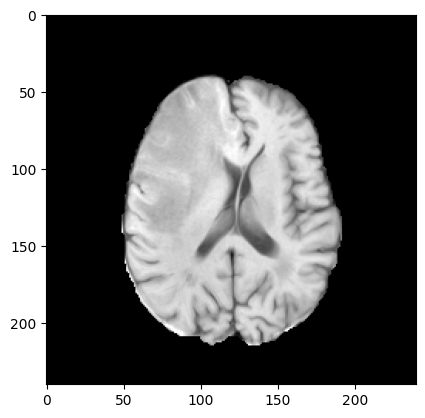

In [141]:
images = merge_and_transpose_images_rgb(rotate_90_deg_rgb(load_rgb_patient("sub-02063373")))
plt.imshow(images[80,:,:,0], cmap = "gray")

shape: (155, 240, 240, 4)
Max value: 1.0
Min value: 0.0


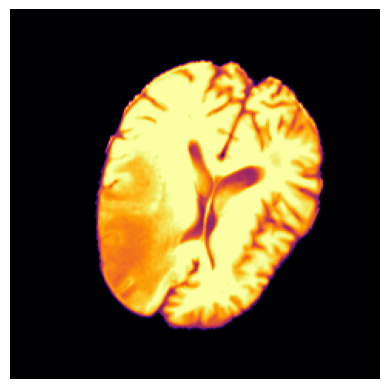

In [48]:
patient_images = prepare_images("sub-02063373")
print(f"shape: {patient_images.shape}")

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal"),
    tf.keras.layers.RandomBrightness(factor = (-0.2, 0.4), value_range=(0, 1)),
    #tf.keras.layers.RandomContrast(0.5), # consider removing the random contrast layer as that causes pixel values to go beyond 1
    tf.keras.layers.RandomRotation(factor = (-0.07, 0.07), fill_mode = "nearest"),
    tf.keras.layers.RandomTranslation(
        height_factor = 0.05,
        width_factor = 0.05,
        fill_mode = "nearest"
    )
])

#consider adding some noise

augmented_images = data_augmentation(patient_images)

plt.imshow(np.array(augmented_images[80,:,:,1]), cmap="inferno")
plt.axis("off")

print("Max value:", np.array(augmented_images).max())
print("Min value:", np.array(augmented_images).min())

#### Data Augmentation - Volumentation

In [66]:
from volumentations import *

def get_augmentation():
    return Compose([Flip(2, p=1),
                    Rotate((-30, 30),(0,0),  (0,0), p=0),
                    RandomGamma(p=1)],
                    p=1.0)
#GaussianNoise(var_limit=(0, 5), p=0.2),
# Rotate((-15, 15), (0, 0), (0, 0), p=0.5),
#                     Flip(0, p=0.5),
#                     Flip(1, p=0.5),
#                     Flip(2, p=0.5),
#                     ElasticTransform((0, 0.25), interpolation=2, p=0.1),
#                     RandomGamma(gamma_limit=(0.5, 1.5), p=0.2)]

def augmentor(img):
    aug = get_augmentation()
    data = {'image': img}
    aug_data = aug(**data)
    img = aug_data['image']
    return np.ndarray.astype(img , np.float32)

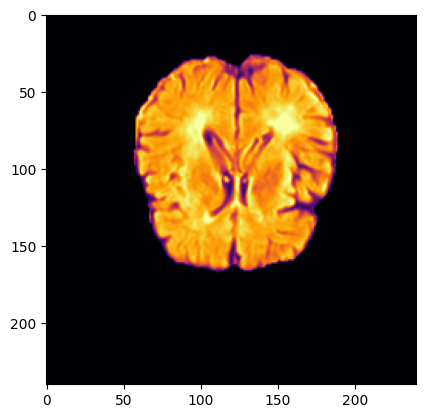

In [89]:

feature_description = {
    "image": tf.io.FixedLenFeature([155, 240, 240, 4], tf.float32),
    "sex": tf.io.FixedLenFeature([2], tf.int64, default_value=[0,0]),
    "age": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "primary": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse(serialize_patient):
    example = tf.io.parse_single_example(serialize_patient, feature_description)
    # input = [example["image"], example["sex"], example["age"]]
    # label = example["primary"]
    image = example["image"]
    image = tf.reshape(image, [155, 240, 240, 4])
    image = data_augmentation(image)
    #image = tf.numpy_function(augmentor, [image], tf.float32)

    return image, example["sex"], example["age"], example["primary"]

dataset = tf.data.TFRecordDataset([path_to_testing_tfr], compression_type="GZIP")
parsed_dataset = dataset.map(parse)



# numpy_image = parsed_dataset.get_single_element()[0].numpy()
# plt.imshow(numpy_image[80,:,:,0], cmap = "inferno")

test_image = parsed_dataset.take(1)
for image, sex, age, primary in test_image:
    numpy_image = image.numpy()
    plt.imshow(numpy_image[80,:,:,0], cmap = "inferno")

#### TFRecord creation

#### Write all the training information to TFRecord

consider adding a seperate patient id to the all the tfrecord entries, to check if any errors occuring during shuffling

In [ ]:
# To-Do:
# shuffle training_patients
# create new tfr file
# go through list of sex, age, created image and primary and write to file
# fucking work

path_to_tfr = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/TFRecords/patient_data_2classes.tfrecord")

def write_to_tfr(patient_id, sex, age, primary):

    image = prepare_images(patient_id)
    imag_data = image.tobytes()

    #sex_data = bytes(sex, "utf-8")

    patient_example = Example(
        features = Features(
            feature = {
                "image": Feature(BytesList(value=imag_data)),
                "sex": Feature(BytesList(value=[sex])),
                "age": Feature(Int64List(value=[age])),
                "primary": Feature(Int64List(value=[primary]))
            }
        )
    )

    with tf.io.TFRecordWriter(path_to_tfr) as f:
        f.write(patient_example.SerializeToString())

write_to_tfr("sub-01641510", sex_array[0], training_patients["age"][0], primary=two_classes_primaries[0])


# Assuming you have your dataset in the following format
dataset = [
    {'sex': [1, 0], 'age': 25, 'primary': 1, 'image': np.random.rand(32, 32, 32, 3)},
    {'sex': [0, 1], 'age': 30, 'primary': 0, 'image': np.random.rand(32, 32, 32, 3)},
    # Add more entries as needed
]

# Function to serialize example
def serialize_example(sex, age, primary, image):
    feature = {
        'sex': tf.train.Feature(int64_list=tf.train.Int64List(value=sex)),
        'age': tf.train.Feature(int64_list=tf.train.Int64List(value=[age])),
        'primary': tf.train.Feature(int64_list=tf.train.Int64List(value=[primary])),
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image[:, :, :, :]).numpy()])),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# Define the output TFRecord file
output_file = 'dataset.tfrecord'

# Write the dataset to TFRecord
with tf.io.TFRecordWriter(output_file) as writer:
    for data in dataset:
        example = serialize_example(data['sex'], data['age'], data['primary'], data['image'])
        writer.write(example)


 

In [2]:
path_to_tfr = "/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/TFRecords/patient_data_2classes.tfrecord"
path_to_testing_tfr = "/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/TFRecords/testing_patient_data_2classes.tfrecord"


safe all patients in one large TFRecord File

In [54]:
def serialize_patient(patientID, sex, age, primary):

    image_data = prepare_images(patientID)

    patient_example = Example(
        features = Features(
            feature = {
                'image': tf.train.Feature(float_list=tf.train.FloatList(value=image_data.ravel())),
                'sex': tf.train.Feature(int64_list=tf.train.Int64List(value= sex)),
                'age': tf.train.Feature(int64_list=tf.train.Int64List(value=[age])),
                'primary': tf.train.Feature(int64_list=tf.train.Int64List(value=[primary])),
            }   
        )
    )

    return patient_example.SerializeToString()

# sex_example = sex_encoded[0]
# id_example = training_patients["participant_id"][0]
# age_example = training_patients["age"][0]
# primary_example = two_classes_primaries[0]
# print(sex_example, id_example, age_example, primary_example)

# Write the dataset to TFRecord
options = tf.io.TFRecordOptions(compression_type="GZIP") # compress the dataset
with tf.io.TFRecordWriter(path_to_tfr, options) as writer:

    for i in tqdm(range(len(training_patients))): # iter over all entities in the dataframe

        sex = sex_encoded[i]
        id = training_patients["participant_id"][i]
        age = training_patients["age"][i]
        primary = two_classes_primaries[i]
        example = serialize_patient(id, sex, age, primary)
        writer.write(example)

100%|██████████| 491/491 [3:27:22<00:00, 25.34s/it]  


#### Create a TFRecord File for testing

splits the testing tfrecord file into 4 seperate files, basically acting as k-folds

In [16]:
#path_to_testing_tfr = "/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/TFRecords/testing_patient_data_2classes.tfrecord"
path_to_testing_tfr = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Data.tmp/testing_patient_data_2classes.tfrecord"

def serialize_patient(patientID, sex, age, primary):

    image_data = prepare_images(patientID)

    patient_example = Example(
        features = Features(
            feature = {
                'image': tf.train.Feature(float_list=tf.train.FloatList(value=image_data.ravel())),
                'sex': tf.train.Feature(int64_list=tf.train.Int64List(value= sex)),
                'age': tf.train.Feature(int64_list=tf.train.Int64List(value=[age])),
                'primary': tf.train.Feature(int64_list=tf.train.Int64List(value=[primary])),
            }   
        )
    )

    return patient_example.SerializeToString()


k = 4
fold_size = 3
testing_patients_lengths = 12


# Write the dataset to TFRecord
options = tf.io.TFRecordOptions(compression_type="GZIP") # compress the dataset

patient_counter = 0

for fold_idx in range(k):

    file_path = f"/Users/LennartPhilipp/Desktop/Uni/Prowiss/Data.tmp/3D_CNN_whole/fold_{fold_idx}.tfrecord"
    with tf.io.TFRecordWriter(file_path, options) as writer:

        for i in range(fold_size):

            sex = sex_encoded[patient_counter]
            id = training_patients["participant_id"][patient_counter]
            age = training_patients["age"][patient_counter]
            primary = two_classes_primaries[patient_counter]
            example = serialize_patient(id, sex, age, primary)
            writer.write(example)
            patient_counter += 1
# with tf.io.TFRecordWriter(path_to_testing_tfr, options) as writer:

#     for i in tqdm(range(12)): # iter over all entities in the dataframe (prev. 8)

#         sex = sex_encoded[i]
#         id = training_patients["participant_id"][i]
#         age = training_patients["age"][i]
#         primary = two_classes_primaries[i]
#         example = serialize_patient(id, sex, age, primary)
#         writer.write(example)

#### Write one TFRecord per patient

In [15]:
path_to_derivatives = Path("/Users/LennartPhilipp/Desktop/testing_data/derivatives/TFRecords")
path_to_preprocessed_patients = Path("/Users/LennartPhilipp/Desktop/testing_data/derivatives/preprocessed_n4_brainlesion_percentile_20240611-125716")

def serialize_patient(patientID, sex, age, primary):

    image_data = prepare_images(patientID)

    patient_example = Example(
        features = Features(
            feature = {
                'image': tf.train.Feature(float_list=tf.train.FloatList(value=image_data.ravel())),
                'sex': tf.train.Feature(int64_list=tf.train.Int64List(value= sex)),
                'age': tf.train.Feature(int64_list=tf.train.Int64List(value=[age])),
                'primary': tf.train.Feature(int64_list=tf.train.Int64List(value=[primary])),
            }   
        )
    )

    return patient_example.SerializeToString()


# Write the dataset to TFRecord
options = tf.io.TFRecordOptions(compression_type="GZIP") # compress the dataset

patients = [patient for patient in os.listdir(path_to_preprocessed_patients) if os.path.isdir(os.path.join(path_to_preprocessed_patients, patient))]

path_to_all_tfr = path_to_derivatives / Path("all_pats_single")
os.makedirs(path_to_all_tfr, exist_ok=True)

for pat in range(len(patients)):

    file_path = str(path_to_all_tfr) + "/" + patients[pat] + ".tfrecord"
    with tf.io.TFRecordWriter(file_path, options) as writer:

        sex = sex_encoded[pat]
        id = training_patients["participant_id"][pat]
        age = training_patients["age"][pat]
        primary = two_classes_primaries[pat]
        example = serialize_patient(id, sex, age, primary)
        writer.write(example)

#### Read TFRecord File

In [3]:
path_to_tsv = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Dateien/dataset_patients_05_24.tsv"

patients = pd.read_csv(path_to_tsv, sep="\t")

[1 0]
46
1


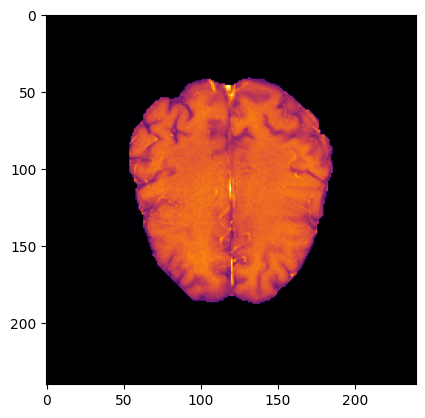

In [7]:
path_to_testing_tfr = "/Users/LennartPhilipp/Desktop/testing_data/derivatives/TFRecords/remote_tfrecords/sub-02063373.tfrecord"

feature_description = {
    "image": tf.io.FixedLenFeature([155, 240, 240, 4], tf.float32),
    "sex": tf.io.FixedLenFeature([2], tf.int64, default_value=[0,0]),
    "age": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "primary": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse(serialize_patient):
    example = tf.io.parse_single_example(serialize_patient, feature_description)
    # input = [example["image"], example["sex"], example["age"]]
    # label = example["primary"]
    image = example["image"]
    image = tf.reshape(image, [155, 240, 240, 4]) #[149, 185, 155, 4] = old size
    
    return image, example["sex"], example["age"], example["primary"]

dataset = tf.data.TFRecordDataset([path_to_testing_tfr], compression_type="GZIP")
parsed_dataset = dataset.map(parse)

test_image = parsed_dataset.take(1)
for image, sex, age, primary in test_image:
    print(sex.numpy())
    print(age.numpy())
    print(primary.numpy())
    numpy_image = image.numpy()
    plt.imshow(numpy_image[100,:,:,0], cmap = "inferno")

# sex
# m = 1, 0
# f = 0, 1

### 2D Images

#### Prepare Images For Training
- load png files
- give options to load mask or cutout
- rotate images 90 degress?
- compress all sequences into one array 

In [7]:
path_to_sliced_images = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices")
#path_to_sliced_images = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_test_slices")

In [8]:
def load_2d_rgb_image(patient_id, include_mask = False, only_cutout = False, save_as_rgb = False):
    # order of sequences t1, t1c, t2, flair, maybe mask

    if save_as_rgb:
        cv2_num = 1
    else: # save as a single gray scale image
        cv2_num = 0

    leasions = []

    patient_files = [file for file in os.listdir(path_to_sliced_images / patient_id) if file.endswith(".png")]

    leasion_ids = {}

    counter = 0

    for file in patient_files:

        leasion = int(file.split("_")[3])

        if leasion not in leasion_ids.values():
            leasion_ids[counter] = leasion
            counter += 1

    #print(leasion_ids)

    # max_leasions = 0
    # for file in patient_files:
    #     leasion = int(file.split("_")[3])

    #     if leasion > max_leasions:
    #         max_leasions = leasion
    
    for leasion in range(len(leasion_ids.keys())):
        
        leasion_files = [file for file in patient_files if int(file.split("_")[3]) == (leasion_ids[leasion])]
        
        t1_image = None
        t1c_image = None
        t2_image = None
        flair_image = None
        mask_image = None

        if only_cutout == True:
            # load only cutout of t1, t1c, t2, flair
            leasion_files = [file for file in leasion_files if "cutout" in file]

            for file in leasion_files:
                sequence = file.split("_")[-2]

                path_to_file = str(path_to_sliced_images / patient_id / file)

                match sequence:
                    case "t1":
                        t1_image = cv2.imread(path_to_file, cv2_num)
                    case "t1c":
                        t1c_image = cv2.imread(path_to_file, cv2_num)
                    case "t2":
                        t2_image = cv2.imread(path_to_file, cv2_num)
                    case "fla":
                        flair_image = cv2.imread(path_to_file, cv2_num)
                    case _:
                        pass

            images = [t1_image, t1c_image, t2_image, flair_image]

        elif include_mask == True:
            # load t1, t1c, t2, flair, mask image

            for file in leasion_files:

                path_to_file = str(path_to_sliced_images / patient_id / file)

                sequence = file.split("_")[-1].split(".")[0]
                
                match sequence:
                    case "t1":
                        t1_image = cv2.imread(path_to_file, cv2_num)
                    case "t1c":
                        t1c_image = cv2.imread(path_to_file, cv2_num)
                    case "t2":
                        t2_image = cv2.imread(path_to_file, cv2_num)
                    case "fla":
                        flair_image = cv2.imread(path_to_file, cv2_num)
                    case _:
                        pass

                if file.endswith("mask.png") and mask_image is None:
                    mask_image = cv2.imread(path_to_file, 0)

            images = [t1_image, t1c_image, t2_image, flair_image, mask_image]

        else:
            # load t1, t1c, t2, flair image

            for file in leasion_files:

                path_to_file = str(path_to_sliced_images / patient_id / file)

                sequence = file.split("_")[-1].split(".")[0]
                #print(sequence)
                match sequence:
                    case "t1":
                        #print("t1 image loaded")
                        t1_image = cv2.imread(path_to_file, cv2_num)
                    case "t1c":
                        t1c_image = cv2.imread(path_to_file, cv2_num)
                    case "t2":
                        t2_image = cv2.imread(path_to_file, cv2_num)
                    case "fla":
                        flair_image = cv2.imread(path_to_file, cv2_num)
                    case _:
                        #print("Wrong sequence set in the load_2d_rgb_image func, please pick a sequence between t1, t1c, t2, flair")
                        pass

            images = [t1_image, t1c_image, t2_image, flair_image]
        
        leasions.append(images)
    
    return leasions

def merge_2d_rgb_images(leasions):

    merged = []

    for leasion in leasions:
        stacked = tf.stack(leasion, axis = -1)
        merged.append(stacked)
    
    return tf.convert_to_tensor(merged)

def prepare_2d_rgb_images(patient_id, include_mask = False, only_cutout = False, save_as_rgb = False):

    leasions = load_2d_rgb_image(patient_id, include_mask, only_cutout, save_as_rgb)
    merged = merge_2d_rgb_images(leasions)

    return merged

(240, 240)


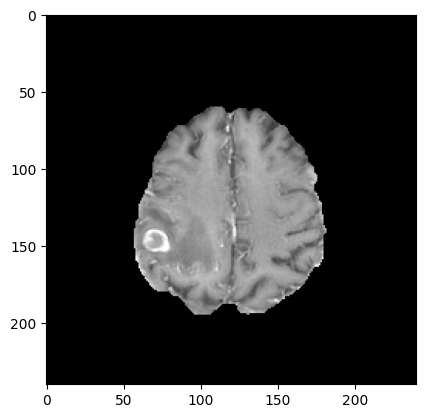

In [15]:
leasions = load_2d_rgb_image(patient_id = "sub-01134825",
                             include_mask = True,
                             only_cutout = False)

plt.imshow(leasions[0][1], cmap = "gray")

print(leasions[0][1].shape)

#merged = merge_2d_rgb_images(leasions)
# plt.imshow(merged[0][:,:,2], cmap = "gray")

#### Data Augmentation

custom layer that adjusts all pixel values to be between 0 and 1

In [62]:
class NormalizeToRange(tf.keras.layers.Layer):
    def __init__(self, zero_to_one=True):
        super(NormalizeToRange, self).__init__()
        self.zero_to_one = zero_to_one

    def call(self, inputs):
        min_val = tf.reduce_min(inputs)
        max_val = tf.reduce_max(inputs)
        if self.zero_to_one:
            # Normalize to [0, 1]
            normalized = (inputs - min_val) / (max_val - min_val)
        else:
            # Normalize to [-1, 1]
            normalized = 2 * (inputs - min_val) / (max_val - min_val) - 1
        return normalized

a simple data augmentation protocol that includes
- horizontal flip
- rescaling to 0 - 1
- random contrast
- random brightness
- random rotation
- rescaling again lol
- random translatio

I had to rescale the images again using a custom layer, so that all images values are between 0 and 1 in the end

shape: (240, 240, 5)
Max value: 1.0
Mean value: 0.18933669
Min value: 0.0


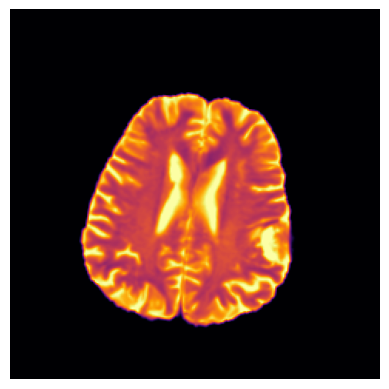

In [69]:
patient_images = merge_2d_rgb_images(load_2d_rgb_image(patient_id = "sub-01921604",
                            include_mask = True,
                            only_cutout = False))[1]
print(f"shape: {patient_images.shape}")

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal"),
    #tf.keras.layers.Rescaling(1/255),
    tf.keras.layers.RandomContrast(0.5), # consider removing the random contrast layer as that causes pixel values to go beyond 1
    tf.keras.layers.RandomBrightness(factor = (-0.2, 0.4)), #, value_range=(0, 1)
    tf.keras.layers.RandomRotation(factor = (-0.1, 0.1), fill_mode = "nearest"),
    NormalizeToRange(zero_to_one=True),
    tf.keras.layers.RandomTranslation(
        height_factor = 0.05,
        width_factor = 0.05,
        fill_mode = "nearest"
    )
])

#consider adding some noise

augmented_images = data_augmentation(patient_images)

plt.imshow(np.array(augmented_images[:,:,2]), cmap="inferno")
plt.axis("off")

print("Max value:", np.array(augmented_images).max())
print("Mean value:", np.array(augmented_images).mean())
print("Min value:", np.array(augmented_images).min())

#### TFRecord Creation

In [9]:
path_to_derivatives = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords")
path_to_preprocessed_patients = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices")

tf.experimental.numpy.experimental_enable_numpy_behavior()

def serialize_2d_patient(image_data, sex, age, primary):

    #print(image_data.shape)

    #image_data = prepare_2d_rgb_images(patientID, include_mask = True, only_cutout = False)

    patient_example = Example(
        features = Features(
            feature = {
                'image': tf.train.Feature(float_list=tf.train.FloatList(value = image_data.ravel())),
                'sex': tf.train.Feature(int64_list=tf.train.Int64List(value = [sex])),
                'age': tf.train.Feature(int64_list=tf.train.Int64List(value = [age])),
                'primary': tf.train.Feature(int64_list=tf.train.Int64List(value= [primary])),
            }   
        )
    )

    return patient_example.SerializeToString()


# Write the dataset to TFRecord
options = tf.io.TFRecordOptions(compression_type="GZIP") # compress the dataset

patients = [patient for patient in os.listdir(path_to_preprocessed_patients) if os.path.isdir(os.path.join(path_to_preprocessed_patients, patient))]

path_to_all_tfr = path_to_derivatives / Path("all_pats_single_rgb")


if os.path.exists(path_to_all_tfr):
    # get list of already processed patients
    tfr_already_created_patients = [patient for patient in os.listdir(path_to_all_tfr) if os.path.isdir(os.path.join(path_to_all_tfr, patient))]

    for patient in tfr_already_created_patients:
        # check if the number of leasions equals the number of tfr files
        path_to_patient = path_to_all_tfr / patient
        tfr_files = [f for f in os.listdir(path_to_patient) if f.endswith(".tfrecord")]
        num_leasions = len(tfr_files)
        leasions = prepare_2d_rgb_images(patient, include_mask = False, only_cutout = True, save_as_rgb=True)
        if num_leasions != len(leasions):
            # delete the patient folder
            shutil.rmtree(path_to_patient)
            tfr_already_created_patients.remove(patient)
else:
    os.makedirs(path_to_all_tfr, exist_ok=False)

for pat in tqdm(patients):

    if pat in tfr_already_created_patients:
        print(f"Skipping patient {pat}")
        continue

    # create patient folder
    path_to_patient = path_to_all_tfr / pat
    os.makedirs(path_to_patient, exist_ok=False)

    leasions = prepare_2d_rgb_images(pat, include_mask = False, only_cutout = True, save_as_rgb=True)
    print(f"found {len(leasions)} leasion(s) in patient {pat}")

    for i in range(len(leasions)):

        file_path = str(path_to_patient) + "/" + pat + "_" + str(i) + ".tfrecord"
        with tf.io.TFRecordWriter(file_path, options) as writer:

            sex = sex_array_dict[pat]
            leasion_data = leasions[i]
            age = int(list(training_patients[training_patients["participant_id"] == pat]["age"])[0])
            primary = specific_primaries_dict[pat]
            # print("________________")
            # print(age)
            example = serialize_2d_patient(leasion_data, sex, age, primary)
            writer.write(example)

  0%|          | 0/471 [00:00<?, ?it/s]

Skipping patient sub-01812518
Skipping patient sub-02095303
Skipping patient sub-01729917
Skipping patient sub-02155605
Skipping patient sub-01892684
Skipping patient sub-01104996
Skipping patient sub-01710250
Skipping patient sub-02092748
Skipping patient sub-01883957
Skipping patient sub-01381621
Skipping patient sub-01979997
Skipping patient sub-02038513
Skipping patient sub-02148372
Skipping patient sub-01398968
Skipping patient sub-01702596
Skipping patient sub-93002557
Skipping patient sub-01452858
Skipping patient sub-01009590
Skipping patient sub-02122538
Skipping patient sub-01699532
Skipping patient sub-01589112
Skipping patient sub-02095961
Skipping patient sub-02110064
Skipping patient sub-02145605
Skipping patient sub-02031868
Skipping patient sub-01652130
Skipping patient sub-01122863
Skipping patient sub-01108350
Skipping patient sub-95001254
Skipping patient sub-01691369
Skipping patient sub-01969755
Skipping patient sub-02018743
Skipping patient sub-02137073
Skipping p

 60%|██████    | 283/471 [07:16<04:50,  1.54s/it]

found 2 leasion(s) in patient sub-01893873


 60%|██████    | 284/471 [08:29<05:55,  1.90s/it]

found 1 leasion(s) in patient sub-02199356


 61%|██████    | 285/471 [09:06<06:40,  2.15s/it]

found 1 leasion(s) in patient sub-02021781


 61%|██████    | 286/471 [09:42<07:42,  2.50s/it]

found 4 leasion(s) in patient sub-01201117


 61%|██████    | 287/471 [12:07<13:49,  4.51s/it]

found 2 leasion(s) in patient sub-01498464


 61%|██████    | 288/471 [13:19<17:50,  5.85s/it]

found 1 leasion(s) in patient sub-01134825


 61%|██████▏   | 289/471 [13:56<20:20,  6.70s/it]

found 1 leasion(s) in patient sub-01958155


 62%|██████▏   | 290/471 [14:31<23:33,  7.81s/it]

found 1 leasion(s) in patient sub-02094355


 62%|██████▏   | 291/471 [15:07<27:45,  9.25s/it]

found 1 leasion(s) in patient sub-01513891


 62%|██████▏   | 292/471 [15:43<33:02, 11.08s/it]

found 3 leasion(s) in patient sub-01732889


 62%|██████▏   | 293/471 [17:31<58:25, 19.69s/it]

found 11 leasion(s) in patient sub-01879950


 62%|██████▏   | 294/471 [24:08<3:03:45, 62.29s/it]

found 7 leasion(s) in patient sub-01150136


 63%|██████▎   | 295/471 [28:31<4:24:11, 90.07s/it]

found 3 leasion(s) in patient sub-01456719


 63%|██████▎   | 296/471 [30:24<4:33:46, 93.86s/it]

found 2 leasion(s) in patient sub-02063398


 63%|██████▎   | 297/471 [31:39<4:21:58, 90.34s/it]

found 2 leasion(s) in patient sub-01890298


 63%|██████▎   | 298/471 [32:54<4:11:13, 87.13s/it]

found 1 leasion(s) in patient sub-01935938


 63%|██████▎   | 299/471 [33:32<3:36:31, 75.53s/it]

found 1 leasion(s) in patient sub-01199093


 64%|██████▎   | 300/471 [34:09<3:07:31, 65.80s/it]

found 2 leasion(s) in patient sub-01220269


 64%|██████▍   | 301/471 [35:22<3:12:06, 67.81s/it]

found 2 leasion(s) in patient sub-02128777


 64%|██████▍   | 302/471 [36:37<3:16:32, 69.78s/it]

found 1 leasion(s) in patient sub-01518885


 64%|██████▍   | 303/471 [37:14<2:49:40, 60.60s/it]

found 1 leasion(s) in patient sub-01668785


 65%|██████▍   | 304/471 [37:51<2:29:36, 53.75s/it]

found 1 leasion(s) in patient sub-02020631


 65%|██████▍   | 305/471 [38:29<2:15:32, 48.99s/it]

found 14 leasion(s) in patient sub-02142561


 65%|██████▍   | 306/471 [47:04<8:30:56, 185.80s/it]

found 1 leasion(s) in patient sub-02088565


 65%|██████▌   | 307/471 [47:41<6:27:22, 141.72s/it]

found 3 leasion(s) in patient sub-02026964


 65%|██████▌   | 308/471 [49:30<5:59:14, 132.23s/it]

found 1 leasion(s) in patient sub-01083248


 66%|██████▌   | 309/471 [50:07<4:40:11, 103.78s/it]

found 5 leasion(s) in patient sub-01789555


 66%|██████▌   | 310/471 [53:10<5:41:53, 127.42s/it]

found 1 leasion(s) in patient sub-01583797


 66%|██████▌   | 311/471 [53:47<4:27:52, 100.46s/it]

found 15 leasion(s) in patient sub-01494236


 66%|██████▌   | 312/471 [1:04:04<11:15:45, 255.00s/it]

found 3 leasion(s) in patient sub-02012594


 66%|██████▋   | 313/471 [1:06:42<9:54:51, 225.90s/it] 

found 5 leasion(s) in patient sub-01681275


 67%|██████▋   | 314/471 [1:09:48<9:20:13, 214.10s/it]

found 1 leasion(s) in patient sub-02181503


 67%|██████▋   | 315/471 [1:10:24<6:57:51, 160.72s/it]

found 2 leasion(s) in patient sub-02090355


 67%|██████▋   | 316/471 [1:11:38<5:47:57, 134.70s/it]

found 1 leasion(s) in patient sub-01041137


 67%|██████▋   | 317/471 [1:12:15<4:30:20, 105.33s/it]

found 1 leasion(s) in patient sub-01710310


 68%|██████▊   | 318/471 [1:12:52<3:36:21, 84.85s/it] 

found 2 leasion(s) in patient sub-02097980


 68%|██████▊   | 319/471 [1:14:04<3:24:53, 80.88s/it]

found 1 leasion(s) in patient sub-02019520


 68%|██████▊   | 320/471 [1:14:40<2:49:56, 67.53s/it]

found 1 leasion(s) in patient sub-02090169


 68%|██████▊   | 321/471 [1:15:18<2:26:17, 58.52s/it]

found 0 leasion(s) in patient sub-02100576
found 2 leasion(s) in patient sub-96003928


 69%|██████▊   | 323/471 [1:16:31<1:59:22, 48.39s/it]

found 3 leasion(s) in patient sub-01699419


 69%|██████▉   | 324/471 [1:18:23<2:37:03, 64.11s/it]

found 2 leasion(s) in patient sub-01673701


 69%|██████▉   | 325/471 [1:19:36<2:41:38, 66.43s/it]

found 5 leasion(s) in patient sub-02014467


 69%|██████▉   | 326/471 [1:22:41<3:58:44, 98.79s/it]

found 4 leasion(s) in patient sub-02000864


 69%|██████▉   | 327/471 [1:25:08<4:29:25, 112.26s/it]

found 1 leasion(s) in patient sub-01830168


 70%|██████▉   | 328/471 [1:25:45<3:36:32, 90.85s/it] 

found 1 leasion(s) in patient sub-93003757


 70%|██████▉   | 329/471 [1:26:22<2:58:12, 75.30s/it]

found 1 leasion(s) in patient sub-01769144


 70%|███████   | 330/471 [1:27:00<2:30:42, 64.13s/it]

found 2 leasion(s) in patient sub-02014068


 70%|███████   | 331/471 [1:28:14<2:36:35, 67.11s/it]

found 1 leasion(s) in patient sub-01499528


 70%|███████   | 332/471 [1:28:50<2:14:33, 58.08s/it]

found 2 leasion(s) in patient sub-01189050


 71%|███████   | 333/471 [1:30:03<2:23:43, 62.49s/it]

found 2 leasion(s) in patient sub-01874079


 71%|███████   | 334/471 [1:31:16<2:29:55, 65.66s/it]

found 1 leasion(s) in patient sub-01762556


 71%|███████   | 335/471 [1:31:54<2:09:34, 57.16s/it]

found 2 leasion(s) in patient sub-01131702


 71%|███████▏  | 336/471 [1:33:08<2:19:58, 62.21s/it]

found 1 leasion(s) in patient sub-01415245


 72%|███████▏  | 337/471 [1:33:44<2:01:37, 54.46s/it]

found 3 leasion(s) in patient sub-01754011


 72%|███████▏  | 338/471 [1:35:35<2:38:08, 71.35s/it]

found 2 leasion(s) in patient sub-01562247


 72%|███████▏  | 339/471 [1:36:49<2:38:58, 72.26s/it]

found 9 leasion(s) in patient sub-01190738


 72%|███████▏  | 340/471 [1:42:24<5:29:43, 151.02s/it]

found 2 leasion(s) in patient sub-01064662


 72%|███████▏  | 341/471 [1:43:38<4:37:03, 127.87s/it]

found 21 leasion(s) in patient sub-02127770


#### Read TFRecord File

[1 0]
72
1


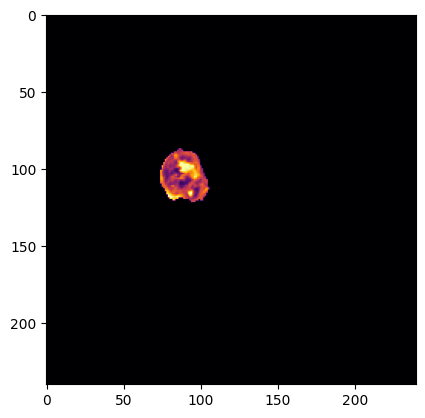

In [32]:
path_to_testing_tfr = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/test_regensburg_slices_tfrecords/all_pats_single/sub-01732889/sub-01732889_0.tfrecord"

num_images = 4

feature_description = {
    "image": tf.io.FixedLenFeature([240, 240, num_images], tf.float32),
    "sex": tf.io.FixedLenFeature([2], tf.int64, default_value=[0,0]),
    "age": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "primary": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse(serialize_patient):
    example = tf.io.parse_single_example(serialize_patient, feature_description)
    # input = [example["image"], example["sex"], example["age"]]
    # label = example["primary"]
    image = example["image"]
    image = tf.reshape(image, [240, 240, num_images]) #[149, 185, 155, 4] = old size
    
    return image, example["sex"], example["age"], example["primary"]

dataset = tf.data.TFRecordDataset([path_to_testing_tfr], compression_type="GZIP")
parsed_dataset = dataset.map(parse)

test_image = parsed_dataset.take(1)
for image, sex, age, primary in test_image:
    print(sex.numpy())
    print(age.numpy())
    print(primary.numpy())
    numpy_image = image.numpy()
    plt.imshow(numpy_image[:,:,3], cmap = "inferno")

# sex
# m = 1, 0
# f = 0, 1

## Yale Dataset

In [3]:
path_to_yale_preprocessed_images = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/CIA metstobrain/yale_dataset_normalized")
path_to_met_slices = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/CIA metstobrain/yale_metastases")
path_to_yale_excel = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/CIA metstobrain/Pretreat-MetsToBrain-Masks_clin_20240410.xlsx")

In [6]:
yale_training_patients = pd.read_excel(path_to_yale_excel, sheet_name="Data")

yale_patient_ids = yale_training_patients["BraTS_MET_ID"].tolist()
print(yale_patient_ids)
print(len(yale_training_patients))

# preprocessed_patients = [patient for patient in os.listdir(str(path_to_all_preprocessed_files)) if os.path.isdir(os.path.join(path_to_all_preprocessed_files / patient))]

# for patient in preprocessed_patients:
#     if patient not in patient_ids:
#         print(patient)

[86, 89, 90, 96, 97, 98, 100, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 229, 230, 231, 232, 233, 234, 235, 237, 238, 239, 240, 241, 242, 243, 244, 245, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 258, 260, 262, 263, 264, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 280, 281, 282, 283, 284, 285, 286, 288, 289, 290, 291, 292, 293, 294, 295, 296, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 309, 310]
200


### Unify primary classes

count different primaries that exist within the Yale Dataset. As one can see, most primaries belong to lung cancer (86 + 17 = 103), after that Melanoma (41), then Breast Cancer (26), Renal cell carcinoma (16) and lastly Gastrointestinal cancers (16).

In [9]:
# primaries are written like this: 1, 2, 3, 4, 5
# explanation:
# 1 = Breast cancer; 2 = Gastrointestinal cancers;
# 3 = Small cell lung cancer; 4 = Melanoma;
# 5 = Non small cell lung cancer; 6 = Renal cell carcinoma; 7 = Other

# given a certain amount of classes, e.g. 3:
# create the following classes: lung, melanoma, other
yale_primaries_array = yale_training_patients["Primary"]
print(yale_primaries_array.value_counts())

Primary
5    86
4    41
1    26
3    17
6    16
2    14
Name: count, dtype: int64


Next we'll merge the two lung categories into one, meaning we combine category number 3 and category number 5 and turn it into a new category, 0.

In [14]:
# replace each 5 and 3 in the yale_primaries_array with a 0

yale_primaries_array = yale_primaries_array.replace(5, 0)
yale_primaries_array = yale_primaries_array.replace(3, 0)

print(yale_primaries_array.value_counts())

Primary
0    103
4     41
1     26
6     16
2     14
Name: count, dtype: int64


In [35]:
yale_class_primaries = return_specific_primaries(yale_primaries_array, specific_classes = [1], dataset="Yale")

print(yale_class_primaries.value_counts())

Primary
1    103
0     97
Name: count, dtype: int64
Primary
1    103
0     97
Name: count, dtype: int64


In [36]:
labels = yale_class_primaries.to_numpy()

classes = np.array([1, 0])

weights = class_weight.compute_class_weight(class_weight="balanced",
                                            classes=classes,
                                            y=labels)

print(weights)

[0.97087379 1.03092784]


### One hot encode sex
The sex in the yale dataset is encoded as such:\
0 = Male; 1 = Female\
Then it's time to adjust the dataset accordingly:

In [40]:
yale_sex_array = yale_training_patients["Sex"]

print(yale_sex_array.value_counts())

# str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
# str_lookup_layer.adapt(sex_array)
# sex_tensors = str_lookup_layer(sex_array)

# sex_test = sex_tensors[0].numpy()
# print(sex_test)

yale_sex_encoded = []
for sex in yale_sex_array:
    if sex == 0: # Male
        yale_sex_encoded.append([1, 0])
    elif sex == 1: # Femal
        yale_sex_encoded.append([0, 1])
    else:
        print(f"unknown sex: {sex}")
        yale_sex_encoded.append([0, 0])

print(yale_sex_encoded)

Sex
1    125
0     75
Name: count, dtype: int64
[[0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1],

### Prepare Images for training

#### 3D images

In [132]:
def load_yale_patient(patientID):
    images = []
    # get all four sequences

    if patientID < 100:
        patientID = "0" + str(patientID)

    patientID = str(patientID)

    patients = os.listdir(path_to_yale_preprocessed_images)
    patient_folder_name = [patient for patient in patients if patientID in patient][0]
    patient_path = Path(patient_folder_name)

    image_names = [file for file in os.listdir(path_to_yale_preprocessed_images / patient_path) if "normalized" in file]
    
    # load them
    for name in image_names:
        path_to_image = path_to_yale_preprocessed_images / patient_path / Path(name)
        image = nib.load(path_to_image)
        data = image.get_fdata()
        #tensor = tf.convert_to_tensor(data, dtype = float)
        images.append(data)
    
    if len(images) != 4:
        print(f"Warning: either too many or too few images for {patientID} (#{len(images)})")
    
    # return four images as array
    return images


def rotate_90_deg_yale(images):
    """rotates images by 90 degrees"""
    # rotate images
    rotated_images = []
    for image in images:
        rotated_image = ndimage.rotate(np.array(image), angle = 90)
        #rotated_images.append(tf.convert_to_tensor(rotated_image, dtype = float))
        rotated_images.append(rotated_image)
    
    # return back
    return rotated_images

def merge_and_transpose_images_yale(images):
    """merge images so that the fourth dimension used for the different sequences"""
    # merge image
    stacked = tf.stack(images, axis = -1)

    new_order = [2, 0, 1, 3]
    transposed = np.transpose(stacked, axes=new_order)

    # rearranges the sequence to order to the only correct one: T1, T1c, T2, FLAIR
    yale_sequence_order = [0, 2, 3, 1]
    new_sequence_images = transposed[..., yale_sequence_order]

    # transposed = tf.transpose(stacked, perm = new_order)
    return new_sequence_images

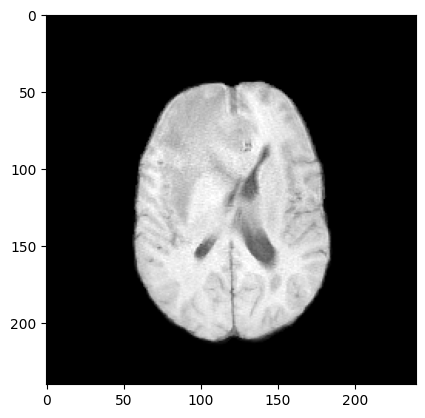

In [136]:
images = merge_and_transpose_images_yale(rotate_90_deg_yale(load_yale_patient(135)))
plt.imshow(images[80,:,:,0], cmap = "gray")

#### 2D images